In [435]:
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
import requests
import nltk
import pickle
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob
import textcleaner as tc
from nltk.stem import WordNetLemmatizer 
import spacy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.datasets import make_multilabel_classification

from src.models.docs_and_topics import docs_to_topics_lda, docs_to_topics_nmf
from src.models.stop_words_list_1 import stop_words_1
from src.models  import cosine_sim 

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
! pip install --editable ..

Obtaining file:///Users/greenapple/project4
  Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0
  Running setup.py develop for src


# Load positions

In [22]:
# Load tokenized text for WA
pickling_out = open('/Users/greenapple/project4/data/processed/jobs_skills_token.pkl', 'rb')
jobs_skills = pickle.load(pickling_out)

In [23]:
jobs_skills.shape

(8939, 20)

In [28]:
# Data scientist/analyst jobs only
jobs_skills_d = jobs_skills.loc[jobs_skills.type=='positive']
jobs_skills_d.reset_index(inplace=True, drop=True)
jobs_skills_d.shape, jobs_skills.shape

((5058, 20), (8939, 20))

In [29]:
jobs_skills_d['type'] = 'data_scientist'

In [30]:
# Not data scientist/analyst jobs only
jobs_skills_n = jobs_skills.loc[jobs_skills.type!='positive']
jobs_skills_n.reset_index(inplace=True, drop=True)
jobs_skills_n.shape, jobs_skills.shape

((3881, 20), (8939, 20))

# Additional clinical trial and civil engineer jobs

In [24]:
# Load tokenized text for clinical jobs
pickling_out = open('/Users/greenapple/project4/data/processed/jobs_clinical_skills_token.pkl', 'rb')
jobs_skills_clinical = pickle.load(pickling_out)

In [25]:
jobs_skills_clinical.shape

(1655, 13)

In [26]:
jobs_skills_clinical['type'] = 'clinical_trial_specialist'

In [27]:
# Load tokenized text for engineer jobs
pickling_out = open('', 'rb')
jobs_skills_engineer = pickle.load(pickling_out)

FileNotFoundError: [Errno 2] No such file or directory: ''

In [ ]:
jobs_skills_engineer.shape

In [ ]:
jobs_skills_engineer['type'] = 'civil_engineer'

In [ ]:
all_jobs = concat([jobs_skills_d, jobs_skills_clinical, jobs_skills_d], axis=1)

In [74]:
# Remove later
all_jobs = pd.concat([jobs_skills_d, jobs_skills_clinical], axis=1)

In [75]:
all_jobs.shape

(5058, 34)

# Load resumes

In [169]:
# Load resumes:

# Data resumes
pickling_out = open('/Users/greenapple/project4/data/resumes/resumes_metis_111319', 'rb')
data_list = pickle.load(pickling_out)

# Clinical resumes
pickling_out = open('/Users/greenapple/project4/data/resumes/resumes_clinical_111319', 'rb')
clinical_list = pickle.load(pickling_out)

# Engineer resumes
pickling_out = open('/Users/greenapple/project4/data/resumes/resumes_engineer_111319', 'rb')
engineer_list = pickle.load(pickling_out)

In [172]:
# To dataframe
data_list_df = pd.DataFrame(data_list, columns = ['description'], index = list(range(0,24)))
data_list_df['type'] = 'data_scientist'

clinical_list_df = pd.DataFrame(list(clinical_list), columns = ['description'], index = list(range(24,48)))
clinical_list_df['type'] = 'clinical_trial_specialist'

engineer_list_df = pd.DataFrame(engineer_list, columns = ['description'], index = list(range(48,72)))
engineer_list_df['type'] = 'civil_engineer'

resumes = pd.concat([data_list_df, clinical_list_df, engineer_list_df])

In [175]:
# Process resumes
from src.features.pre_process_text import pre_process
from src.features.tokenize_text import tokenize_word, tokenize_noun, tokenize_lemma, tokenize_noun_lemma

resumes['clean_skills'] = resumes.description.apply(pre_process) # clean

# Tokenize:
resumes['noun_skills'] = resumes.clean_skills.apply(tokenize_noun)
resumes['word_skills'] = resumes.clean_skills.apply(tokenize_word)
resumes['noun_lemma_skills'] = resumes.clean_skills.apply(tokenize_noun_lemma)
resumes['lemma_skills'] = resumes.clean_skills.apply(tokenize_lemma)

In [176]:
resumes_little = resumes[:24]
resumes_little.shape

(24, 7)

In [179]:
print(resumes_little.description[17])

herbert pan

MZ panherbert@gmail.com & +1-909-859-5884 9 Greater Los Angeles Reigion, CA 91789 in panherbert/ © panherbert

 

+ projects

 

Social Media Followers Market Segmentation
+ To perform market segment and topic analysis to gain valuable insights from targeted account.
+ Data: Scraped =150.9K followers account and =6.3M tweets.
+ Tools: AWS EC2, Google Cloud Compute, MongoDB

 

How Can We Improve Our Products?
+ Performed sentiment and topic analysis on targeted SKUs.
+ Data: Scraped =36,000 product reviews over =10 SKUs.
+ Tools: AWS, MongoDB, Amazon Comprehend, Google Cloud Natural Language API, NMF, LSA.

Banking Telemarketing Analysis
+ Rana series of classification models and used linear classifiers to predict the outcome of the telemarketing activities.
+ Tools: PostgreSQL, SQLalchemy, Seaborn, Pandas, Numpy, Scikit-learn

Parking Availability
+ Built a linear regression model with polynomial Features to predict parking availability around the Seattle region.
* Tools:

In [348]:
resumes_tiny = resumes[:5]

# Recommender

In [ ]:
# Recomender optimization. 
# Bring to life if have time.

# Parameters:
# - Models: LSA, NMF, LDA
# - Components (topics): 5, 10, 15, 20
# - Tokenization: word, noun, lemma, noun_lemma
# - min_df and max_df

# Optimization metric:
# A sum of two deltas. The goal is to maximize the sum.
# the delta is a difference in average cosine similarity for:
# delta_1 = metis resumes with data scientist postings - metis resumes with clinical trial postings.
# delta_2 = metis resumes with data scientist postings - metis resumes with civil engineer postings.

In [428]:
# LDA
lda_vec_pos, lda_vec_res = docs_to_topics_lda(
                                              components=20, 
                                              word_num=5,                           
                                              positions=jobs_skills_d.noun_skills,
                                              resumes = resumes_tiny.noun_skills,
                                              max_df=0.6,
                                              min_df = 0.0,
                                              stop_words = stop_words_1)

# Cosine similarity
score = cosine_sim.similarity(lda_vec_pos, lda_vec_res)

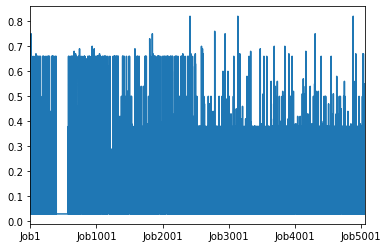

In [429]:
score.Resume1.plot()

In [414]:
# Return 5 top positions
top_pos = recommender(score.Resume1, 5)
top_pos

,Position ID,Similarity score
0,Job2415,0.82
1,Job3137,0.82
2,Job4880,0.82
3,Job2788,0.76
4,Job2945,0.75


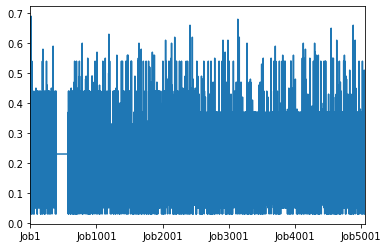

In [362]:
score.Resume4.plot()

In [338]:
# Return 5 top positions
top_pos = recommender(score.Resume2, 5)
top_pos

,Position ID,Similarity score
0,4255,0.90
1,3475,0.87
2,1652,0.87
3,1185,0.87
4,967,0.87


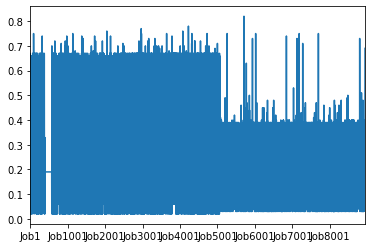

In [290]:
score.Resume5.plot()

In [337]:
# Look at description that return low cosine similarity
score.loc[score.Resume2==0.02]
# score.loc[score.description.isna()]
score['Job_ID'] = score.index
score.reset_index(inplace=True, drop=True)

data = pd.concat([score,jobs_skills], axis=1)

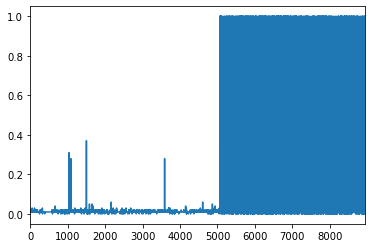

In [114]:
# Non data science posting
score.Resume11.plot()

In [447]:
## NMF
nmf_vec_pos, nmf_vec_res = docs_to_topics_nmf(max_df=0.99,
                  min_df = 0.0,
                  stop_words = stop_words_1,
                  components=20, 
                  positions=jobs_skills_d.noun_skills,
                  word_num=5,
                  resumes = resumes_tiny.noun_skills)

# Cosine similarity
score = cosine_sim.similarity(nmf_vec_pos, nmf_vec_res)

# Return 5 top positions
top_pos = recommender(score.Resume1, 10)

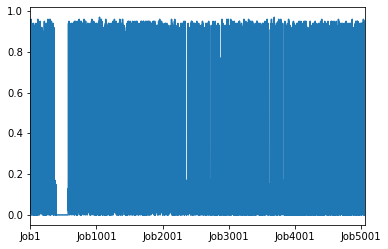

In [448]:
score.Resume1.plot()

In [ ]:
# LSA
lsa_vec_pos, lsa_vec_res = docs_to_topics_lsa(max_df=0.99,
                  min_df = 0.001,
                  stop_words = stop_words_1,
                  components=20, 
                  positions=jobs_skills_d.lemma_skills,
                  word_num=5,
                  resumes = resumes.lemma_skills)

# Cosine similarity
score = similarity(lsa_vec_pos, lsa_vec_res)

# Return 5 top positions
top_pos = recommender(score.Resume1, 5)
top_pos_n = recommender(score.Resume6, 5)
top_pos, top_pos_n

In [ ]:
score

In [ ]:
jobs_skills_d.skills[4627]

In [ ]:
resumes.description[5]

In [ ]:
top_pos = recommender(score.Resume7, 5)
top_pos

# Functions

In [89]:
def recommender(score, num_pos):
    best = score.sort_values(ascending=False)[:num_pos]
    best = pd.Series.to_frame(best, name = 'Similarity score')
    best.reset_index(level=0, inplace=True)
    best.rename(columns={'index':'Position ID'}, inplace=True)
    
    return best

In [434]:
%%writefile '/Users/greenapple/project4/src/models/docs_and_topics.py'

from src.models.stop_words_list_1 import stop_words_1
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.decomposition import NMF

def docs_to_topics_lda(
                  components, 
                  word_num,
                  positions,
                  resumes,
                  max_df=0.45,
                  min_df = 0.001,
                  stop_words = stop_words_1):
    
    tf_idf = TfidfVectorizer(ngram_range=(1, 2),
                            max_df = max_df,
                            min_df = min_df,
                            stop_words = stop_words)   

    components = components  # number of LSA components
    lda = LatentDirichletAllocation(components, random_state = 5)

    # reduce dimensionality
    lda_vec_pos = lda.fit_transform(tf_idf.fit_transform(positions).toarray())  
    lda_vec_res = lda.transform(tf_idf.transform(resumes).toarray())  
    
    return lda_vec_pos, lda_vec_res


def docs_to_topics_lsa(max_df,
                  min_df,
                  stop_words,
                  components, 
                  positions,
                  word_num,
                  resumes):
    
    tf_idf = TfidfVectorizer(ngram_range=(1, 2),
                            max_df = max_df,
                            min_df = min_df,
                            stop_words = stop_words)   

    components = components  # number of LSA components
    lsa = TruncatedSVD(components, random_state = 5)

    # reduce dimensionality
    lsa_vec_pos = lsa.fit_transform(tf_idf.fit_transform(positions).toarray())  
    lsa_vec_res = lsa.transform(tf_idf.transform(resumes).toarray())  
    
    return lsa_vec_pos, lsa_vec_res

def docs_to_topics_lsa(max_df,
                  min_df,
                  stop_words,
                  components, 
                  positions,
                  word_num,
                  resumes):
    
    tf_idf = TfidfVectorizer(ngram_range=(1, 2),
                            max_df = max_df,
                            min_df = min_df,
                            stop_words = stop_words)   

    components = components  # number of LSA components
    lsa = TruncatedSVD(components, random_state = 5)

    # reduce dimensionality
    lsa_vec_pos = lsa.fit_transform(tf_idf.fit_transform(positions).toarray())  
    lsa_vec_res = lsa.transform(tf_idf.transform(resumes).toarray())  
    
    return lsa_vec_pos, lsa_vec_res


def docs_to_topics_nmf(max_df,
                  min_df,
                  stop_words,
                  components, 
                  positions,
                  word_num,
                  resumes):
    
    tf_idf = TfidfVectorizer(ngram_range=(1, 2),
                            max_df = max_df,
                            min_df = min_df,
                            stop_words = stop_words)   

    components = components  # number of LSA components
    nmf = NMF(components, random_state = 5)

    # reduce dimensionality
    nmf_vec_pos = nmf.fit_transform(tf_idf.fit_transform(positions).toarray())  
    nmf_vec_res = nmf.transform(tf_idf.transform(resumes).toarray())  
    
    return nmf_vec_pos, nmf_vec_res

Overwriting /Users/greenapple/project4/src/models/docs_and_topics.py


In [32]:
# Pre-process text
def pre_process(text):
    text_sub = re.sub('[/.\n:-]', ' ', text)  # Remove "/" and "."
    text_sub = re.sub('[,\(\)]', '', text_sub).lower()  # Remove "," and capital letters
    text_sub = re.sub('[^a-z\s]', '', text_sub) # Keep alphanumer characters only
#     re.sub('[%s]' % re.escape(string.punctuation), ' ', my_text)

    return text_sub

In [33]:
# Tokenize text
def tokenize_lemma(text):
        
    # processer = spacy.load('en')
    tokenizer = spacy.load('en_core_web_sm')

    text_obj = tokenizer(text)
    text_str = ' '.join([token.lemma_ for token in text_obj if not token.is_stop])
    return text_str

In [34]:
# Vectorize
def tf_idf(text1, text2):
    tfidf = TfidfVectorizer(ngram_range=(1, 2),               # vectorizer
                        stop_words='english', 
                        token_pattern="\\b[a-z][a-z]+\\b")
    X_tfidf = tfidf.fit_transform(text1).toarray()            # vectorize text1
    Z_tfidf = tfidf.transform(text2).toarray()                # vectorize text1
    
    
#     print('text1{}'.format(pd.DataFrame(X_tfidf, columns=tfidf.get_feature_names()).head(5)))
#     print('text2{}'.format(pd.DataFrame(Z_tfidf, columns=tfidf.get_feature_names()).head(5)))
    
    return X_tfidf, Z_tfidf

In [35]:
# Reduce dimensionality:
def lsa(X, Z):
    lsa = TruncatedSVD(4)
    X_lsa = lsa.fit_transform(X)
    Z_lsa = lsa.transform(Z)
  
    
    return X_lsa, Z_lsa

In [54]:
%%writefile '/Users/greenapple/project4/src/models/cosine_sim.py'

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def similarity(X_red, Z_red):
    score = cosine_similarity(X_red, Z_red).round(2)
    
    column_labels = ['Resume'+str(i) for i in range(1, Z_red.shape[0]+1)]
    row_labels = ['Job'+str(i) for i in range(1, X_red.shape[0]+1)]
    
    
    
    similarity_df = pd.DataFrame(score, columns=column_labels, index=row_labels)
    
    #Remove later
#     similarity_df['clean_text '] = jobs_skills.clean_text
#     similarity_df['type'] = jobs_skills.type
#     similarity_df['job_title'] = jobs_skills.job_title
#     similarity_df['description'] = jobs_skills.job_title
    
    return similarity_df

Overwriting /Users/greenapple/project4/src/models/cosine_sim.py
